# Library Import


In [1]:
import torch, torchvision
import cv2
import matplotlib_inline
import matplotlib.pyplot as plt
import numpy as np
from datasetsloader import TUMDataset
from preprocessing import get_bbox_points, resize_image_and_bboxes, extract_features
import random
from dcp.haze_remover import HazeRemover
import joblib

(20, 1437)


In [2]:
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [3]:
SEED = 99
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

# Load dataset


In [6]:
dataset = TUMDataset(
  [
    "./datasets/a9_dataset_r01_s01/_new_labels",
    "./datasets/a9_dataset_r01_s02/_new_labels",
    "./datasets/a9_dataset_r01_s03/_new_labels",
  ],
  "datasets/categories/category.json",
)

In [7]:
def collate_fn(batch):
  imgs, annots = zip(*batch)
  imgs = torch.stack(imgs, dim=0)
  return imgs, annots

loader = torch.utils.data.DataLoader(
  dataset,
  shuffle=True,
  batch_size=64,
  collate_fn=collate_fn,
)

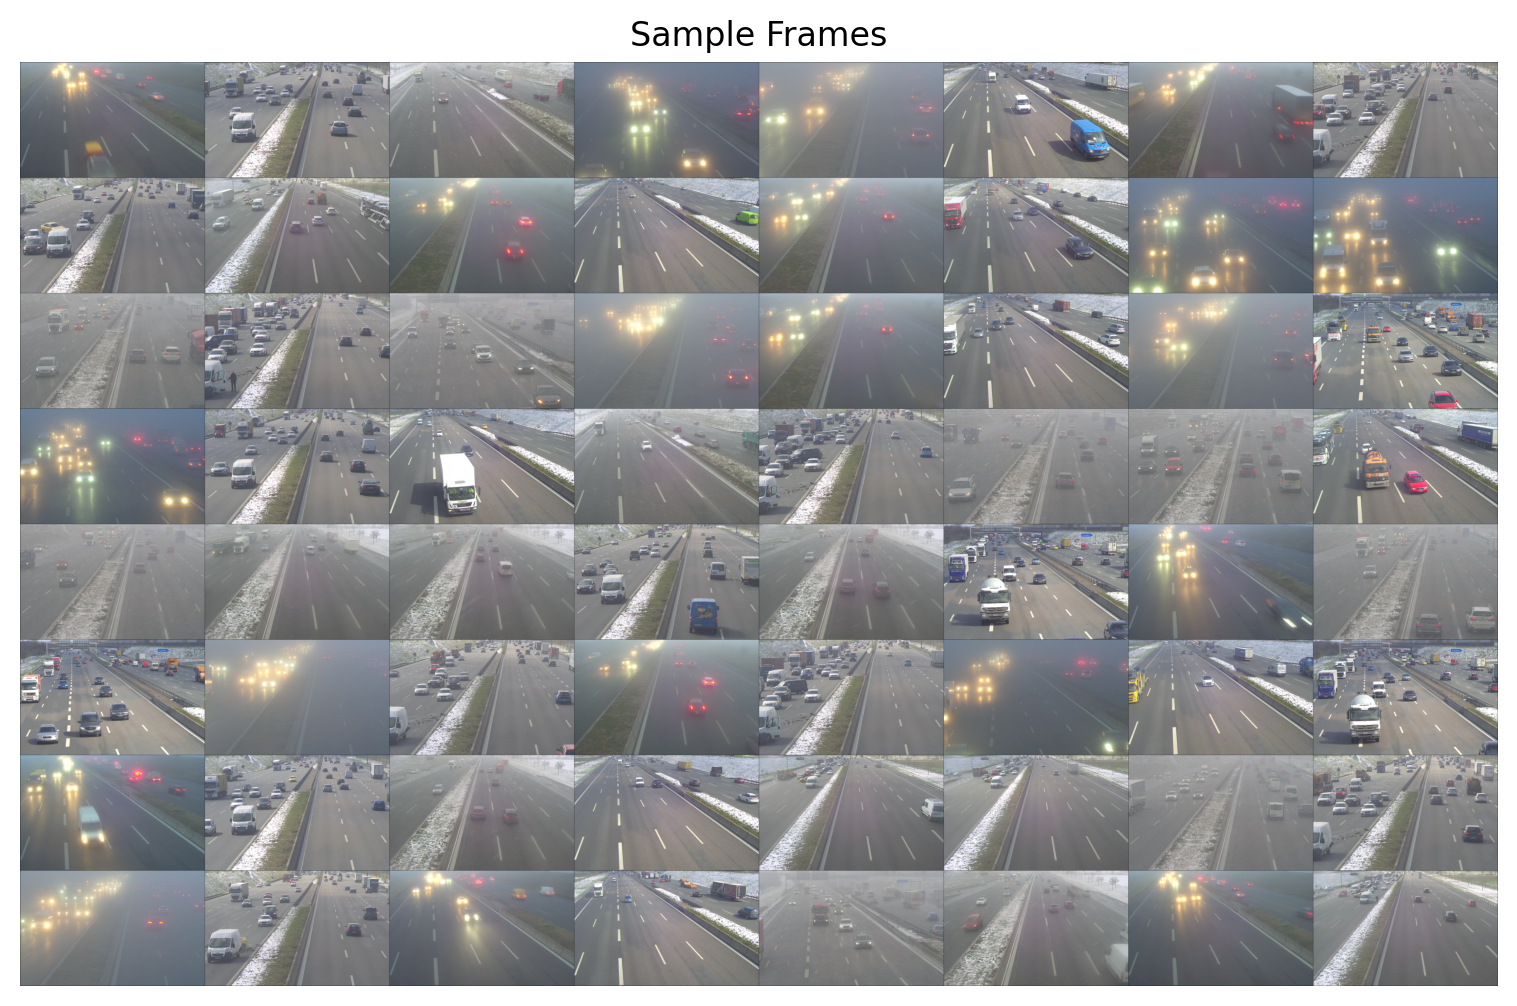

In [8]:
for x, y in loader:
  sample_image = x[0]
  sample_label = y[0]
  
  break

grid = torchvision.utils.make_grid(x, padding=2)

plt.figure(figsize=(16, 6))

plt.title("Sample Frames")
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')

plt.show()

In [15]:
i = 0

for x, y in loader:
  sample_image = x[0]
  sample_label = y[0]
  
  print(y)
  
  if i >= 5:
    break
  
  i += 1

({'proposed_features': tensor([[-2.5329e+00,  3.8157e+00,  1.1283e+00,  ...,  0.0000e+00,
          0.0000e+00,  9.0000e+01],
        [-3.7307e+00,  2.1188e+00, -8.5698e-01,  ...,  0.0000e+00,
          5.0000e+00,  1.4950e+03],
        [-7.3067e-01,  8.1974e-01,  8.3556e-02,  ...,  2.0000e+00,
          6.0000e+00,  2.2200e+02],
        ...,
        [-2.4551e+00,  2.7925e+00,  9.5311e-01,  ...,  0.0000e+00,
          0.0000e+00,  1.8000e+02],
        [-3.0216e+00,  4.0244e+00,  9.6125e-01,  ...,  0.0000e+00,
          0.0000e+00,  2.4300e+02],
        [-3.4084e+00,  1.9292e+00,  2.0458e-01,  ...,  1.0000e+01,
          4.8000e+01,  1.4230e+03]]), 'labels': tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]), 'bbox_deltas': tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0

In [9]:
cats = dataset.get_categories()
categories = []
for c in cats:
  categories.append(c['name'])

In [11]:
category_count = [0, 0, 0, 0, 0, 0]

i = 0
for Xs, Ys in loader:
  for y in Ys:
    for annot in y:
      category_count[annot['category_id'] - 1] += 1
      
  i += 1

In [ ]:
# for i in range(6):
#   print(f'{categories[i]}: {category_count[i]}')

NameError: name 'category_count' is not defined

In [11]:
category_count = [0, 0, 0, 0, 0, 0, 0]

for x, y in dataset:
  for label in y['labels']:
    category_count[label - 1] += 1

KeyboardInterrupt: 

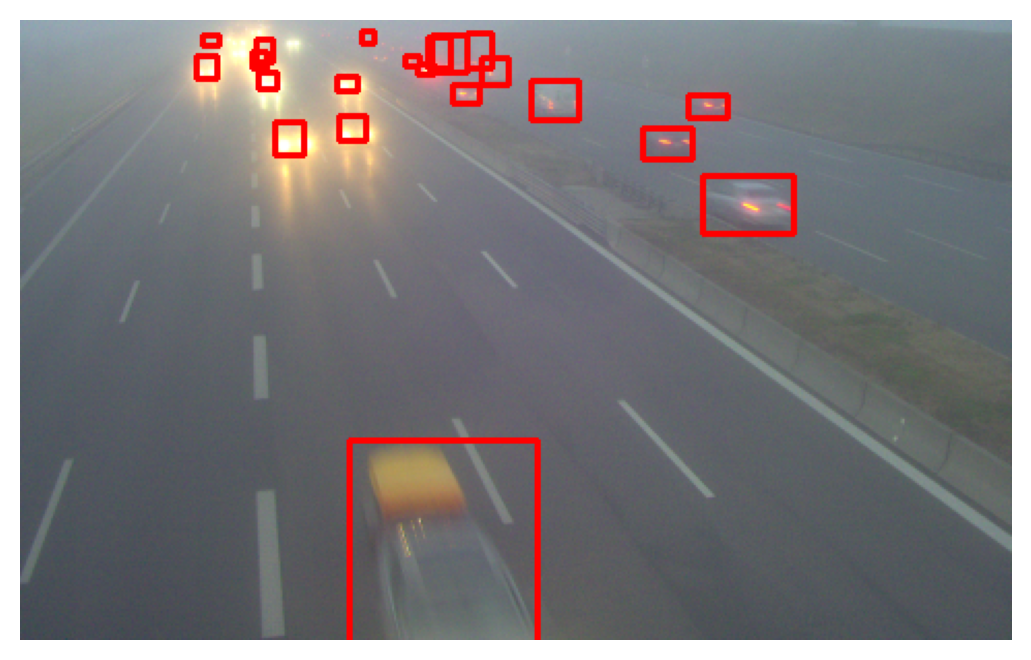

In [ ]:
raw_img = sample_image.permute(1, 2, 0).detach().cpu().numpy().copy()
res_img, res_annot = resize_image_and_bboxes(raw_img, sample_label)

if res_img.max() <= 1.0:
    res_img = (res_img * 255.0).astype('uint8')
else:
    res_img = res_img.astype('uint8')

object_detected_img = res_img.copy()

for bbox in res_annot['target_bboxes']:

    x, y, x2, y2 = get_bbox_points(bbox)

    cv2.rectangle(object_detected_img, (x, y), (x2, y2), (255, 0, 0), 2)

plt.imshow(object_detected_img)
plt.axis("off")
plt.show()


In [16]:
res_img.shape, res_annot

((300, 480, 3),
 {'target_bboxes': [[88, 7, 8, 5],
   [247, 29, 23, 19],
   [114, 9, 8, 11],
   [209, 31, 13, 9],
   [115, 25, 9, 8],
   [159, 203, 91, 123],
   [199, 7, 17, 18],
   [223, 18, 13, 13],
   [323, 36, 19, 11],
   [112, 15, 7, 8],
   [192, 21, 8, 5],
   [153, 27, 10, 7],
   [330, 75, 44, 28],
   [197, 8, 11, 15],
   [301, 52, 24, 15],
   [165, 5, 6, 6],
   [85, 17, 10, 11],
   [216, 6, 12, 17],
   [123, 49, 14, 16],
   [154, 46, 13, 12],
   [186, 17, 7, 5]],
  'category_id': [2,
   3,
   1,
   2,
   2,
   2,
   4,
   3,
   2,
   3,
   2,
   2,
   2,
   1,
   2,
   3,
   3,
   1,
   2,
   2,
   2],
  'proposed_bboxes': array([], shape=(0, 4), dtype=float64),
  'proposed_features': array([], shape=(0, 0), dtype=float64)})

Needs to normalize images because some conditions hinder with region proposal search


In [17]:
def is_foggy(img, threshold: int = 200):
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  avg_variance = np.var(gray_img)

  return avg_variance < threshold

In [18]:
def normalize_image(img):
    img = img.astype(np.float32) / 255.0

    dehazed_img = img.copy()
    if is_foggy(img):
        haze_remover = HazeRemover()
        dehazed_img = haze_remover.remove_haze(img)

    dehazed_img = (np.clip(dehazed_img, 0, 1) * 255).astype(np.uint8)
    final_img = cv2.bilateralFilter(dehazed_img, 9, 75, 75)

    return final_img


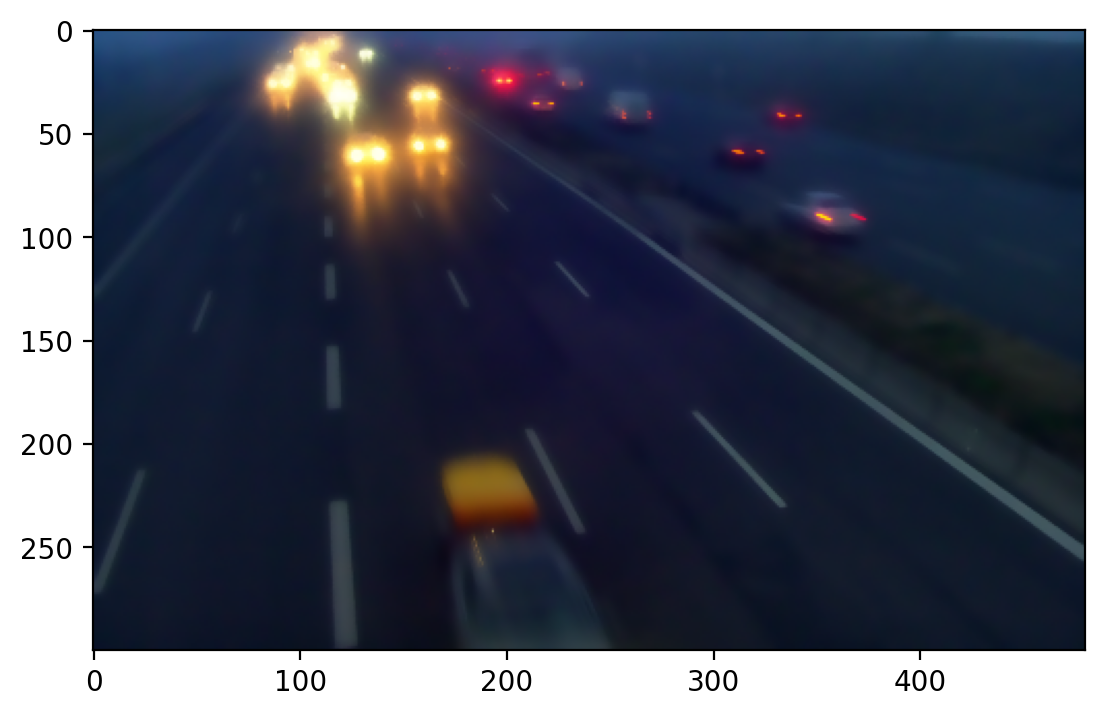

In [19]:
normalized_image = normalize_image(res_img)

plt.imshow(normalized_image)
plt.show()

In [20]:
def get_boxes(raw_img: np.ndarray) -> list:
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

  ss.setBaseImage(raw_img)
  ss.switchToSelectiveSearchFast()
  
  sizeStrategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategySize()
  colorStrategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyColor()
  fillStrategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyFill()
  textureStrategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyTexture()
  
  ssStrategies = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyMultiple()
  ssStrategies.addStrategy(sizeStrategy, 0.4)
  ssStrategies.addStrategy(colorStrategy, 0.2)
  ssStrategies.addStrategy(fillStrategy, 0.6)
  ssStrategies.addStrategy(textureStrategy, 0.1)
  
  ss.addStrategy(ssStrategies)

  return ss.process()

In [21]:
def draw_boxes(img: np.ndarray, coords: list) -> np.ndarray:
  result = img.copy()

  for coord in coords:
    x, y, x2, y2 = get_bbox_points(coord)
    cv2.rectangle(result, (x, y), (x2, y2), (0, 255, 0), 2)

  return result

In [22]:
norm_boxes = get_boxes(normalized_image.copy())

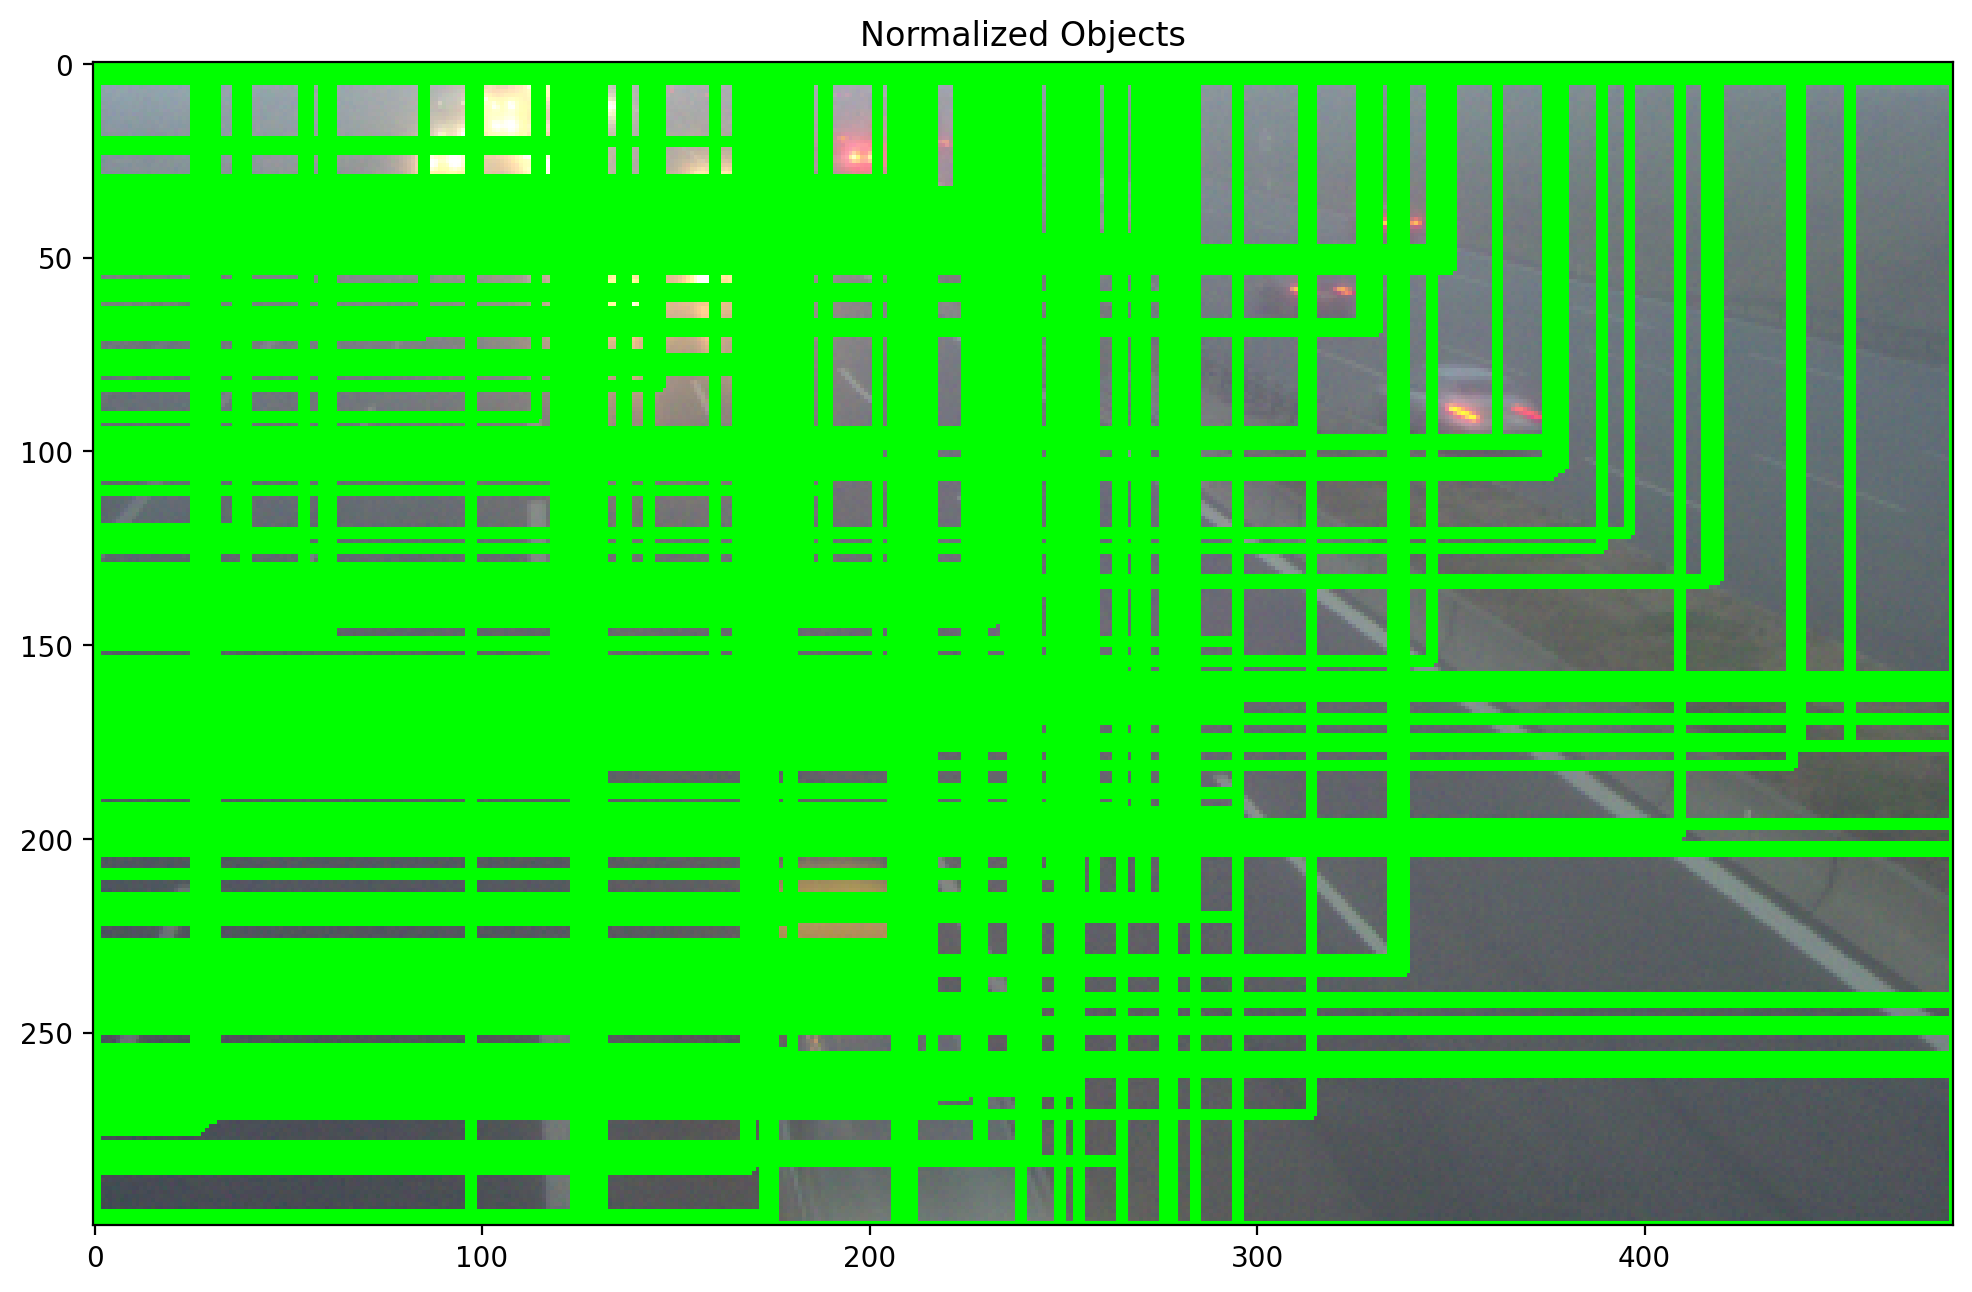

In [23]:
norm_pred_img = draw_boxes(res_img, norm_boxes)

plt.figure(figsize=(12, 12))
plt.title('Normalized Objects')
plt.imshow(norm_pred_img)

plt.show()

In [24]:
box, features = extract_features(res_img)

In [25]:
features.shape

(20, 1437)

# Bootstrap PCA for HOG


In [112]:
from sklearn.decomposition import PCA

hog = cv2.HOGDescriptor((128, 64), (16, 16), (8, 8), (8, 8), 9)
hog_features = []

i = 0

for x, y in loader:
  
  for img, lbls in zip(x[:20], y[:20]):
    for lbl in lbls:
      x, y, x2, y2 = get_bbox_points(lbl['bbox'])
      x = max(x, 0)
      y = max(y, 0)
      
      cropped_img = img.permute(1, 2, 0).numpy()[y:y2, x:x2]

      resized_img = cv2.cvtColor(cv2.resize(cropped_img, (128, 64), interpolation=cv2.INTER_AREA), cv2.COLOR_RGB2GRAY)
      hog_feat = hog.compute(resized_img).flatten()
    
      hog_features = np.array(hog_feat) if len(hog_features) == 0 else np.vstack((hog_features, hog_feat))
  
      if len(hog_features.shape) >= 2 and hog_features.shape[0] >= 2000:
        break
    
    if len(hog_features.shape) >= 2 and hog_features.shape[0] >= 2000:
      break

In [113]:
hog_features.shape

(2089, 3780)

In [119]:
pca = PCA(n_components=0.95)
pca.fit(hog_features)
  
print(f'K: {pca.n_components_}')

joblib.dump(pca, './outputs/hog_pca.joblib')

K: 839


['./outputs/hog_pca.joblib']

In [28]:
X = cv2.imread('datasets/a9_dataset_r01_s01/_images/s040_camera_basler_north_16mm/1607511150_232235957_s040_camera_basler_north_16mm.png')
X = cv2.resize(X, None, fx=0.25, fy=0.25)
boxes, features = extract_features(X)

print(features.shape)

(20, 1437)


In [ ]:
np.load('datasets/_extracted_features/1607511137_833303862_s040_camera_basler_north_16mm.npy')

array([[130., 185.,  19., ...,   0.,   2., 130.],
       [123., 198.,  45., ...,   0.,   1., 176.],
       [266.,  80.,  44., ...,   5.,  24., 999.],
       ...,
       [235.,   0.,  31., ...,   0.,   0., 951.],
       [238., 163.,  66., ...,   3.,  16., 508.],
       [447., 236.,  33., ...,   0.,   0.,  28.]], shape=(20, 1441))